In [1]:
pip install yfinance

  Preparing metadata (setup.py) ... done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=c1b2861872327a00ad24c6e98fee49adcc0ab511de81cf5e244dcaf1e903c35a
  Stored in directory: /root/.cache/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 444.6 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 1.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

In [153]:
# Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]

NUM_DAYS = 12    # The number of days of historical data to retrieve
INTERVAL = '2m'     # Sample rate of historical data
symbol = 'LAURUSLABS.NS'      # Symbol of the desired stock
end_date = datetime.date(2022, 6, 5)
pred_date = end_date + datetime.timedelta(1)

[*********************100%***********************]  1 of 1 completed
                                close
Datetime                             
2022-05-24 09:15:00+05:30  573.549988
2022-05-24 09:17:00+05:30  574.000000
2022-05-24 09:19:00+05:30  573.299988
2022-05-24 09:21:00+05:30  573.349976
2022-05-24 09:23:00+05:30  573.849976
...                               ...
2022-06-03 15:23:00+05:30  553.650024
2022-06-03 15:25:00+05:30  553.950012
2022-06-03 15:27:00+05:30  553.000000
2022-06-03 15:29:00+05:30  553.349976
2022-06-06 15:30:00+05:30  551.450012

[1692 rows x 1 columns]
(1692, 1)
(1692, 1)


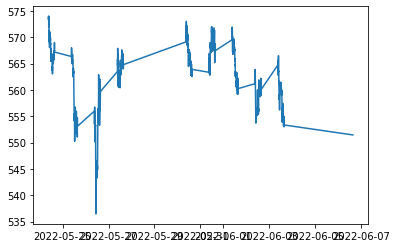

In [154]:
start = (end_date - datetime.timedelta(NUM_DAYS))
end = end_date
df = yf.download(symbol, start = start, end = end, interval = INTERVAL)
df.rename(columns = { 'Close' : 'close', 'Open' : 'open', 'High' : 'high', 'Low' : 'low', 'Volume' : 'volume'}, inplace = True)
df = df.iloc[:,3:4]
train_dataset = df.values

print(df)
print(df.shape)
print(train_dataset.shape)
# df['close'].plot()
tmp = df[-150:]
plt.plot(df)


[*********************100%***********************]  1 of 1 completed
                                close
Datetime                             
2022-06-06 09:15:00+05:30  554.099976
2022-06-06 09:17:00+05:30  554.049988
2022-06-06 09:19:00+05:30  556.549988
2022-06-06 09:21:00+05:30  557.349976
2022-06-06 09:23:00+05:30  555.400024
...                               ...
2022-06-06 15:23:00+05:30  551.500000
2022-06-06 15:25:00+05:30  551.349976
2022-06-06 15:27:00+05:30  551.549988
2022-06-06 15:29:00+05:30  551.900024
2022-06-06 15:30:00+05:30  551.450012

[189 rows x 1 columns]
(189, 1)


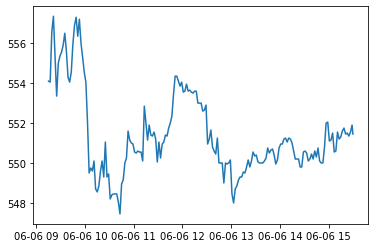

In [155]:
TEST_DAYS = 1
test_start = (pred_date)
test_end = (pred_date + datetime.timedelta(TEST_DAYS))
test_df = yf.download(symbol, start = test_start, end = test_end, interval = INTERVAL)
test_df.rename(columns = { 'Close' : 'close', 'Open' : 'open', 'High' : 'high', 'Low' : 'low', 'Volume' : 'volume'}, inplace = True)
test_df = test_df.iloc[:,3:4]
test_dataset = test_df.values

print(test_df)
print(test_df.shape)
tmp1 = test_df[-150:]
plt.plot(test_df)



In [156]:
#Preprocessing the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_dataset_scaled = sc.fit_transform(train_dataset)
print(train_dataset_scaled)

[[0.98801565]
 [1.        ]
 [0.98135786]
 ...
 [0.44074549]
 [0.45006575]
 [0.39946751]]


In [157]:
#Creating a data structure with 120 timesteps and 1 output
n = 120
X_train = []
y_train = []
for i in range(n, train_dataset.shape[0]):
    X_train.append(train_dataset_scaled[i-n:i, 0])
    y_train.append(train_dataset_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [158]:
#Reshaping the input datas structure
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [159]:
print(X_train.shape)

(1572, 120, 1)


In [160]:
#Importing the keras packages
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [161]:
#Initialising the regressor
regressor = Sequential()

In [162]:
#Adding the first LSTM layer and some dropout regularisation layer
regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
#Layer 2
regressor.add(LSTM(units = 150, return_sequences = True))
regressor.add(Dropout(0.2))
#Layer 3
regressor.add(LSTM(units = 150, return_sequences = True))
regressor.add(Dropout(0.2))
#Layer 4
regressor.add(LSTM(units = 150, return_sequences = False))
regressor.add(Dropout(0.2))

In [163]:
#Output layer
regressor.add(Dense(units = 1))

In [164]:
#Compile the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [165]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
50/50 [==============================] - 6s 33ms/step - loss: 0.0227
Epoch 2/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0057
Epoch 3/100
50/50 [==============================] - 2s 34ms/step - loss: 0.0054
Epoch 4/100
50/50 [==============================] - 2s 34ms/step - loss: 0.0054
Epoch 5/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0054
Epoch 6/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0054
Epoch 7/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0051
Epoch 8/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0037
Epoch 9/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0040
Epoch 10/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0040
Epoch 11/100
50/50 [==============================] - 2s 33ms/step - loss: 0.0035
Epoch 12/100
50/50 [==============================] - 2s 32ms/step - loss: 0.0031
Epoch 13/100
50/50 [=====

In [166]:
#Getting the total dataset
total_dataset = pd.concat((df['close'], test_df['close']), axis = 0)
inputs = total_dataset[len(total_dataset)-len(test_df)-n:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
print(len(test_df))

(309, 1)
189


In [167]:
#Creating the data structure
X_test = []
for i in range(n,n+len(test_df)):
    X_test.append(inputs[i-n:i, 0])
    
X_test = np.array(X_test)
# print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

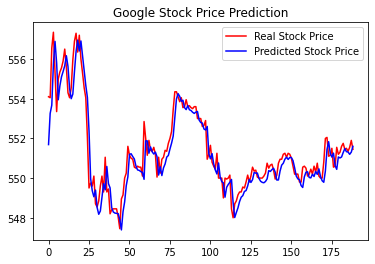

In [168]:
#Plotting
plt.plot(test_dataset, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

In [169]:
mse = ((test_dataset - predicted_stock_price)**2).mean(axis=0)
print(mse)

[0.62093897]
